In [3]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.sparse as sp
import yaml
import time
import gget

import anndata as an
import scanpy as sc
import rapids_singlecell as rsc

import scvi
from scvi.external import SysVI

import cupy as cp
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

from cuml.manifold.umap import simplicial_set_embedding
from scanpy.tools._utils import get_init_pos_from_paga 
from cuml.manifold.umap import find_ab_params

# Enable `managed_memory`
rmm.reinitialize(
    managed_memory=True,
    pool_allocator=False,
)
cp.cuda.set_allocator(rmm_cupy_allocator)

sc.settings.verbosity = 3

# Load in gene data

In [18]:
%%time 
# === Load and filter GTF ===
gpath = "/scratch/indikar_root/indikar1/shared_data/HYB/resources/refdata-gex-GRCh38-2024-A_genes.csv.gz"

gtf = pd.read_csv(gpath)

gtf = gtf[gtf['Feature'] == 'gene']

protein_coding = gtf[gtf['gene_type'] == 'protein_coding']['gene_name'].unique().tolist()
print(f"N protein coding genes: {len(protein_coding)}")

print(gtf.shape)
gtf.head()

N protein coding genes: 19405
(38606, 27)
CPU times: user 7.59 s, sys: 1.17 s, total: 8.76 s
Wall time: 8.92 s


Chromosome   Source Feature   Start     End Score Strand Frame  \
0   GL000009.2  ENSEMBL    gene   56139   58376     .      -     .   
8   GL000194.1  ENSEMBL    gene   53589  115018     .      -     .   
20  GL000194.1  ENSEMBL    gene   53593  115055     .      -     .   
34  GL000195.1  ENSEMBL    gene   42938   49164     .      -     .   
44  GL000213.1  ENSEMBL    gene  108006  139659     .      -     .   

            gene_id  gene_version  ... transcript_name  \
0   ENSG00000278704             1  ...             NaN   
8   ENSG00000277400             1  ...             NaN   
20  ENSG00000274847             1  ...             NaN   
34  ENSG00000276256             1  ...             NaN   
44  ENSG00000277630             4  ...             NaN   

   transcript_support_level  havana_transcript exon_number exon_id  \
0                       NaN                NaN         NaN     NaN   
8                       NaN                NaN         NaN     NaN   
20                      NaN                NaN         NaN     NaN   
34                      NaN                NaN         NaN     NaN   
44                      NaN                NaN         NaN     NaN   

    exon_version     hgnc_id havana_gene  protein_id ccdsid  
0            NaN         NaN         NaN         NaN    NaN  
8            NaN         NaN         NaN         NaN    NaN  
20           NaN  HGNC:31102         NaN         NaN    NaN  
34           NaN         NaN         NaN         NaN    NaN  
44           NaN         NaN         NaN         NaN    NaN  

[5 rows x 27 columns]

# Load data

In [5]:
%%time
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/bone_marrow_processed.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 345 ms, sys: 462 ms, total: 807 ms
Wall time: 2.84 s


AnnData object with n_obs × n_vars = 5608 × 22954
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'leiden', 'bm_cluster', 'CD34_avg', 'CD164_avg', 'PROM1_avg', 'CD48_avg', 'FLT3_avg', 'MPO_avg', 'IRF8_avg', 'CD79A_avg', 'GATA1_avg', 'CD34pos_CD38neg_B0251_HTO_1', 'CD34pos_CD38pos_B0252_HTO_2', 'HTO_pred', 'HTO_pred_label', 'cluster_preds', 'CD164_mean', 'CD34_mean', 'CD38_mean', 'THY1_mean', 'PTPRC_mean', 'MME_mean', 'CD7_mean', 'FLT3_mean', 'PLEK_mean', 'BST2_mean', 'CD37_mean', 'KIT_mean', 'ICAM3_mean', 'CD44_mean', 'EVI2B_mean', 'CD63_mean', 'ITGA2B_mean', 'CSF2RB_mean', 'PROM1_mean', 'ATP1B3_mean',

In [6]:
adata.obs.head()

batch  n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCAAAGGCGATCT-1  bone_marrow               7035                 8.858795   
AAACCAAAGGTGAACG-1  bone_marrow               4440                 8.398635   
AAACCATTCCCTGTCA-1  bone_marrow               6370                 8.759512   
AAACCATTCCGCGATG-1  bone_marrow               3872                 8.261785   
AAACCATTCCTGTCGC-1  bone_marrow               4817                 8.480114   

                    total_counts  log1p_total_counts  \
AAACCAAAGGCGATCT-1       44635.0           10.706296   
AAACCAAAGGTGAACG-1       21652.0            9.982900   
AAACCATTCCCTGTCA-1       40379.0           10.606090   
AAACCATTCCGCGATG-1       15760.0            9.665294   
AAACCATTCCTGTCGC-1       19367.0            9.871378   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACCAAAGGCGATCT-1                   34.950151                    49.842052   
AAACCAAAGGTGAACG-1                   37.091262                    51.533346   
AAACCATTCCCTGTCA-1                   33.547141                    47.425642   
AAACCATTCCGCGATG-1                   37.912437                    51.979695   
AAACCATTCCTGTCGC-1                   30.897919                    43.754841   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACCAAAGGCGATCT-1                    57.302565                    66.010978   
AAACCAAAGGTGAACG-1                    59.763532                    69.517827   
AAACCATTCCCTGTCA-1                    56.833998                    66.601451   
AAACCATTCCGCGATG-1                    59.904822                    69.302030   
AAACCATTCCTGTCGC-1                    52.253834                    62.621986   

                    total_counts_mt  ...  IL7R_mean  CSF3R_mean  CD99_mean  \
AAACCAAAGGCGATCT-1           1521.0  ...   0.044330    0.883304   1.632977   
AAACCAAAGGTGAACG-1            639.0  ...   0.001690    0.040502   0.830491   
AAACCATTCCCTGTCA-1           1230.0  ...   0.048462    0.766552   1.530291   
AAACCATTCCGCGATG-1            545.0  ...   0.000456    0.689305   1.055266   
AAACCATTCCTGTCGC-1            624.0  ...   0.044330    0.883304   1.632977   

                    ITGB2_mean  CD53_mean  CD48_mean  LAIR1_mean  CD74_mean  \
AAACCAAAGGCGATCT-1    0.226036   0.696542   0.286691    0.512722   2.758574   
AAACCAAAGGTGAACG-1    0.092191   0.317394   0.006043    0.125927   1.277790   
AAACCATTCCCTGTCA-1    0.255319   0.621765   0.284677    0.454510   2.544269   
AAACCATTCCGCGATG-1    0.101116   0.598736   0.092357    0.436981   2.921885   
AAACCATTCCTGTCGC-1    0.226036   0.696542   0.286691    0.512722   2.758574   

                    SELL_mean  cell_labels  
AAACCAAAGGCGATCT-1   1.337802          MPP  
AAACCAAAGGTGAACG-1   0.186091      MEG/ERY  
AAACCATTCCCTGTCA-1   1.247767          CMP  
AAACCATTCCGCGATG-1   1.327408          HSC  
AAACCATTCCTGTCGC-1   1.337802          MPP  

[5 rows x 69 columns]

In [7]:
%%time
# --- paths ---------------------------------------------------------------
datas = {
    "bone_marrow": "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/bone_marrow_processed.h5ad",
    "fibroblasts": "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/fib_ihsc_processed.h5ad",
}

# --- load each dataset ---------------------------------------------------
adatas = []
for name, path in datas.items():
    a = sc.read_h5ad(path)
    a.obs["dataset"] = name      # track origin
    
    if name == 'bone_marrow':
        a.obs_names = [f"{cb}_bm" for cb in a.obs_names] # add bone marrow label to cell ids for unique obsnames when merging
    
    adatas.append(a)

# ------------------------------------------------------------------------
# anndata.concat  → union of genes + all obs columns
# ------------------------------------------------------------------------
adata = an.concat(
    adatas,
    axis=0,              # stack cells
    join="outer",        # keep every gene (union)
    merge="first",       # keep all obs columns; fill missing values with NaN
    label="source",      # new obs column with dataset name
    # keys=list(datas),    # used by label and index_unique
    # index_unique="-"     # make cell barcodes unique (adds "-dataset" suffix)
)
adata

CPU times: user 11.3 s, sys: 5.92 s, total: 17.2 s
Wall time: 34.5 s


AnnData object with n_obs × n_vars = 20925 × 26933
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'leiden', 'bm_cluster', 'CD34_avg', 'CD164_avg', 'PROM1_avg', 'CD48_avg', 'FLT3_avg', 'MPO_avg', 'IRF8_avg', 'CD79A_avg', 'GATA1_avg', 'CD34pos_CD38neg_B0251_HTO_1', 'CD34pos_CD38pos_B0252_HTO_2', 'HTO_pred', 'HTO_pred_label', 'cluster_preds', 'CD164_mean', 'CD34_mean', 'CD38_mean', 'THY1_mean', 'PTPRC_mean', 'MME_mean', 'CD7_mean', 'FLT3_mean', 'PLEK_mean', 'BST2_mean', 'CD37_mean', 'KIT_mean', 'ICAM3_mean', 'CD44_mean', 'EVI2B_mean', 'CD63_mean', 'ITGA2B_mean', 'CSF2RB_mean', 'PROM1_mean', 'ATP1B3_mean'

In [8]:
print(adata.obs['cluster'].value_counts())
print(adata.obs['bm_cluster'].value_counts())

cluster
C4    4612
R2    4343
C5    3852
R1    1986
R3     524
Name: count, dtype: int64
bm_cluster
B1    2225
B5    1546
B2     523
B7     505
B4     453
B3     304
B6      52
Name: count, dtype: int64


In [11]:
# add cluster labels to single column
adata.obs['cluster_all'] = np.where(adata.obs['cluster'].notna(), adata.obs['cluster'], adata.obs['bm_cluster'])
print('\n', adata.obs['cluster_all'].value_counts().to_string())

adata.obs['source'] = np.where(adata.obs['batch'].notna(), adata.obs['batch'], adata.obs['source'])
print('\n', adata.obs['source'].value_counts().to_string())

group_map = {
    'R1' : "reprogram",
    'R2' : "reprogram",
    'R3' : "reprogram",
    'C4' : "initial",
    'C5' : "initial",
    'B1' : "bm_other",
    'B2' : "bm_other",
    'B3' : "bm_other",
    'B4' : "bm_other",
    'B5' : "target",
    'B6' : "bm_other",
    'B7' : "bm_other",
}

adata.obs['group'] = adata.obs['cluster_all'].map(group_map)
print('\n', adata.obs['group'].value_counts().to_string())

label_map = {
    'R1' : "R1",
    'R2' : "R2",
    'R3' : "R3",
    'C4' : "initial",
    'C5' : "initial",
    'B1' : "MPP",
    'B2' : "LMPP",
    'B3' : "CMP",
    'B4' : "MEG/ERY",
    'B5' : "HSC",
    'B6' : "GMP",
    'B7' : "CLP",
}

adata.obs['label'] = adata.obs['cluster_all'].map(label_map)
print('\n', adata.obs['label'].value_counts().to_string())

# Clean up obs
keep = ['cluster_all', 'group', 'label', 'dataset', 'source']
columns_to_drop = [x for x in adata.obs.columns if not x in keep]
adata.obs = adata.obs.drop(columns=columns_to_drop)

adata


 cluster_all
C4    4612
R2    4343
C5    3852
B1    2225
R1    1986
B5    1546
R3     524
B2     523
B7     505
B4     453
B3     304
B6      52

 source
hsc            8357
fib            6960
bone_marrow    5608

 group
initial      8464
reprogram    6853
bm_other     4062
target       1546

 label
initial    8464
R2         4343
MPP        2225
R1         1986
HSC        1546
R3          524
LMPP        523
CLP         505
MEG/ERY     453
CMP         304
GMP          52


AnnData object with n_obs × n_vars = 20925 × 26933
    obs: 'dataset', 'source', 'cluster_all', 'group', 'label'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_id', 'gene_type', 'Chromosome', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_rank', 'variances', 'variances_norm'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'X_pca_harmony', 'X_pca_original'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'

In [12]:
adata.obs.groupby('source')['group'].value_counts()

source       group    
bone_marrow  bm_other     4062
             target       1546
fib          initial      6956
             reprogram       4
hsc          reprogram    6849
             initial      1508
Name: count, dtype: int64

# Score cell cycle

In [13]:
%%time
regev_genes = [x.strip() for x in open('../resources/regev_lab_cell_cycle_genes.txt')]
s_genes = regev_genes[:43]
g2m_genes = regev_genes[43:]

sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=s_genes,
    g2m_genes=g2m_genes,
    layer='log_norm',
)

adata.obs[['phase']].head()

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    425 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    428 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
CPU times: user 2.24 s, sys: 1.51 s, total: 3.75 s
Wall time: 3.79 s


phase
AAACCAAAGGCGATCT-1_bm     S
AAACCAAAGGTGAACG-1_bm    G1
AAACCATTCCCTGTCA-1_bm   G2M
AAACCATTCCGCGATG-1_bm    G1
AAACCATTCCTGTCGC-1_bm    G1

CPU times: user 2.43 s, sys: 281 ms, total: 2.71 s
Wall time: 3.5 s


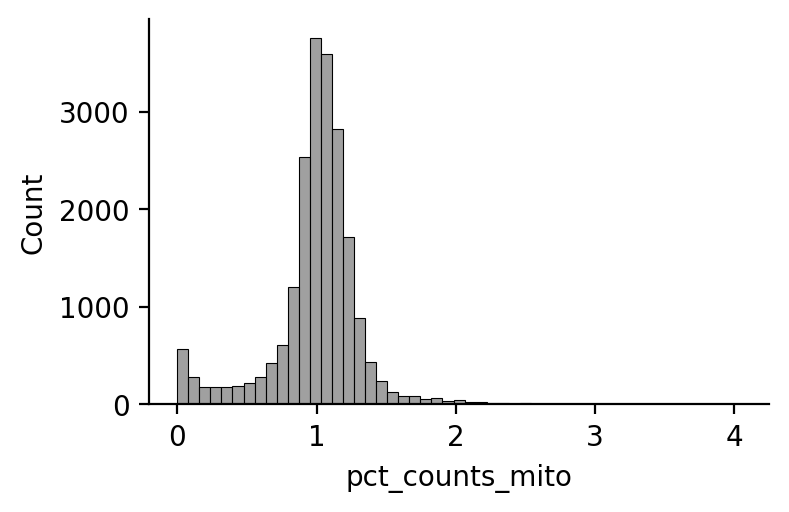

In [14]:
%%time

# Remove cells with high mitocondrial
adata.var["mito"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith("RP")

sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=["mito", "ribo"],
    inplace=True,
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5

sns.histplot(
    adata.obs["pct_counts_mito"],
    bins=51,
    color='grey'
)

sns.despine()

In [15]:
threshold = 2.0
adata = adata[adata.obs['pct_counts_mito'] < threshold, :].copy()
adata

AnnData object with n_obs × n_vars = 20754 × 26933
    obs: 'dataset', 'source', 'cluster_all', 'group', 'label', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_id', 'gene_type', 'Chromosome', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_rank', 'variances', 'variances_norm', 'mito'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'X_pca_harmony', 'X_pca_original'
    v

In [16]:
adata.obs['source'].value_counts()

source
hsc            8336
fib            6960
bone_marrow    5458
Name: count, dtype: int64

# Filter pass (genes)

In [19]:
adata.var['filter_pass'] = True # set the gene filter

# pt genes only
adata.var['filter_pass'] = np.where(~adata.var.index.isin(protein_coding), False, adata.var['filter_pass'])

# disallow GO cell cycle genes
fpath = "../resources/human_cell_cycle_genes.csv"
cdf = pd.read_csv(fpath)
adata.var['filter_pass'] = np.where(adata.var.index.isin(cdf['gene_name'].unique()), False, adata.var['filter_pass'])

# disallow Regev cell cycle genes
fpath = "../resources/regev_lab_cell_cycle_genes.txt"
genes = [x.strip() for x in open(fpath)]
adata.var['filter_pass'] = np.where(adata.var.index.isin(genes), False, adata.var['filter_pass'])

# disallow mitochondrial and ribosomal genes
adata.var['filter_pass'] = np.where(adata.var.index.str.startswith('MT'), False, adata.var['filter_pass'])
adata.var['filter_pass'] = np.where(adata.var.index.str.startswith('RP'), False, adata.var['filter_pass'])

print(adata.var['filter_pass'].value_counts().to_string())

filter_pass
True     15982
False    10951


# scvi

INFO: GPU available: True (cuda), used: True
2025-12-10 15:45:11 | [INFO] GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-12-10 15:45:11 | [INFO] TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-12-10 15:45:11 | [INFO] HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-12-10 15:45:11 | [INFO] You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, re

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 10 records. Best score: 1579.157. Signaling Trainer to stop.


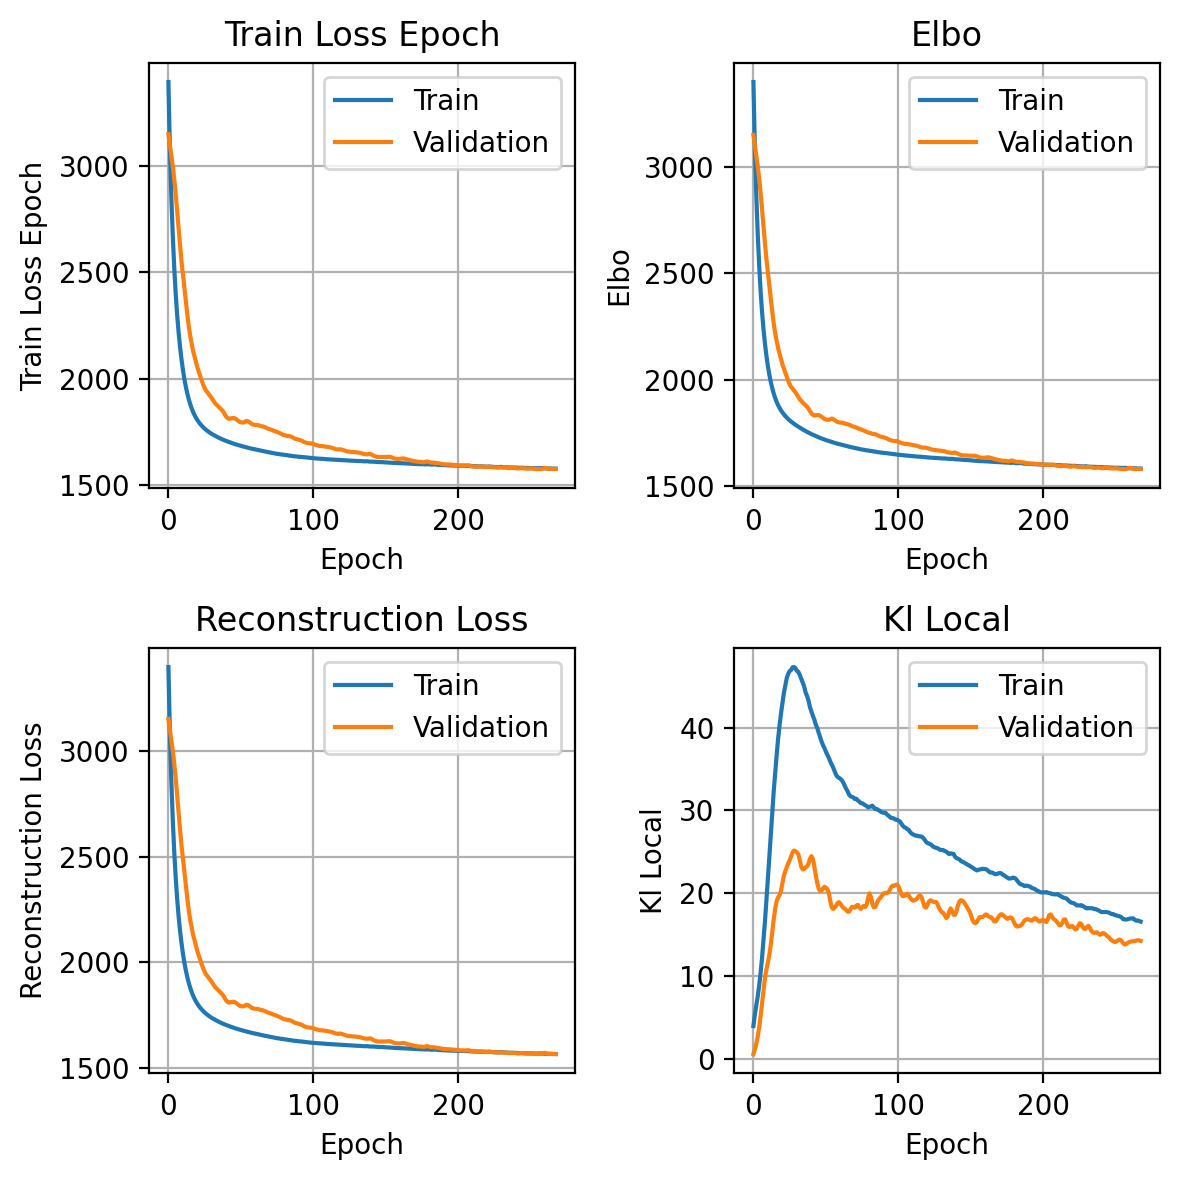

CPU times: user 56.9 s, sys: 44.1 s, total: 1min 41s
Wall time: 1min 46s


In [20]:
%%time
batch_key = "source"

bdata = adata.copy()
bdata = bdata[:, bdata.var['filter_pass']].copy()
bdata.X = bdata.layers['raw_counts'].copy()

rsc.get.anndata_to_GPU(bdata)
rsc.pp.highly_variable_genes(
    bdata,
    flavor="seurat_v3",
    n_top_genes=2500,
    batch_key=batch_key,
)

bdata = bdata[:, bdata.var['highly_variable']].copy()
rsc.get.anndata_to_CPU(bdata)

# scvi
scvi.model.SCVI.setup_anndata(
    bdata, 
    batch_key=batch_key,
    continuous_covariate_keys=['S_score', 'G2M_score'],
)

model = scvi.model.SCVI(
    bdata,
    n_hidden=128,
    n_latent=24,
    n_layers=2, 
    dropout_rate=0.25,
    dispersion='gene-cell',
    gene_likelihood='zinb',
)

model.train(
    max_epochs=1000,
    accelerator='gpu',
    early_stopping_patience=10,
    early_stopping=True,
    batch_size=2 ** 14,
    train_size=0.8,
)

history = model.history

metrics = [
    ("train_loss_epoch", "validation_loss"),
    ("elbo_train", "elbo_validation"),
    ("reconstruction_loss_train", "reconstruction_loss_validation"),
    ("kl_local_train", "kl_local_validation"),
]

plt.rcParams['figure.dpi'] = 200
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes = axes.flatten()

for i, (train_key, val_key) in enumerate(metrics):
    ax = axes[i]
    train_df = history[train_key]
    val_df = history[val_key]

    ax.plot(train_df.index, train_df[train_key], label='Train')
    ax.plot(val_df.index, val_df[val_key], label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(train_key.replace('_train', '').replace('_', ' ').title())
    ax.set_title(train_key.replace('_train', '').replace('_', ' ').title())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# PAGA and UMAP

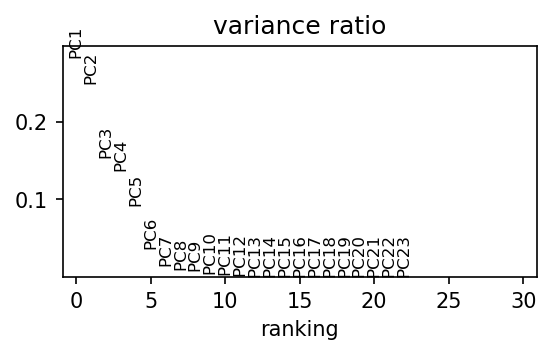

... storing 'dataset' as categorical
... storing 'source' as categorical
... storing 'cluster_all' as categorical
... storing 'group' as categorical
... storing 'label' as categorical
... storing 'phase' as categorical


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


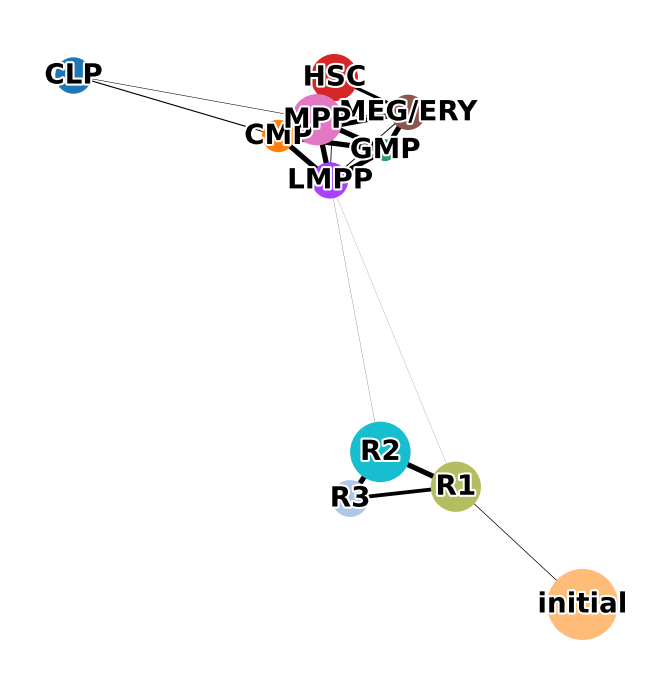

init_pos.shape=(20754, 2) type(init_pos)=<class 'numpy.ndarray'>
data.shape=(20754, 24) type(data)=<class 'cupy.ndarray'>
graph.shape=(20754, 20754) type(graph)=<class 'scipy.sparse._csr.csr_matrix'>
min_dist=0.2 spread=0.55 a=np.float64(3.4688447759133267) b=np.float64(1.1823075110662016)
embedding.shape=(20754, 2) type(embedding)=<class 'cupy.ndarray'>


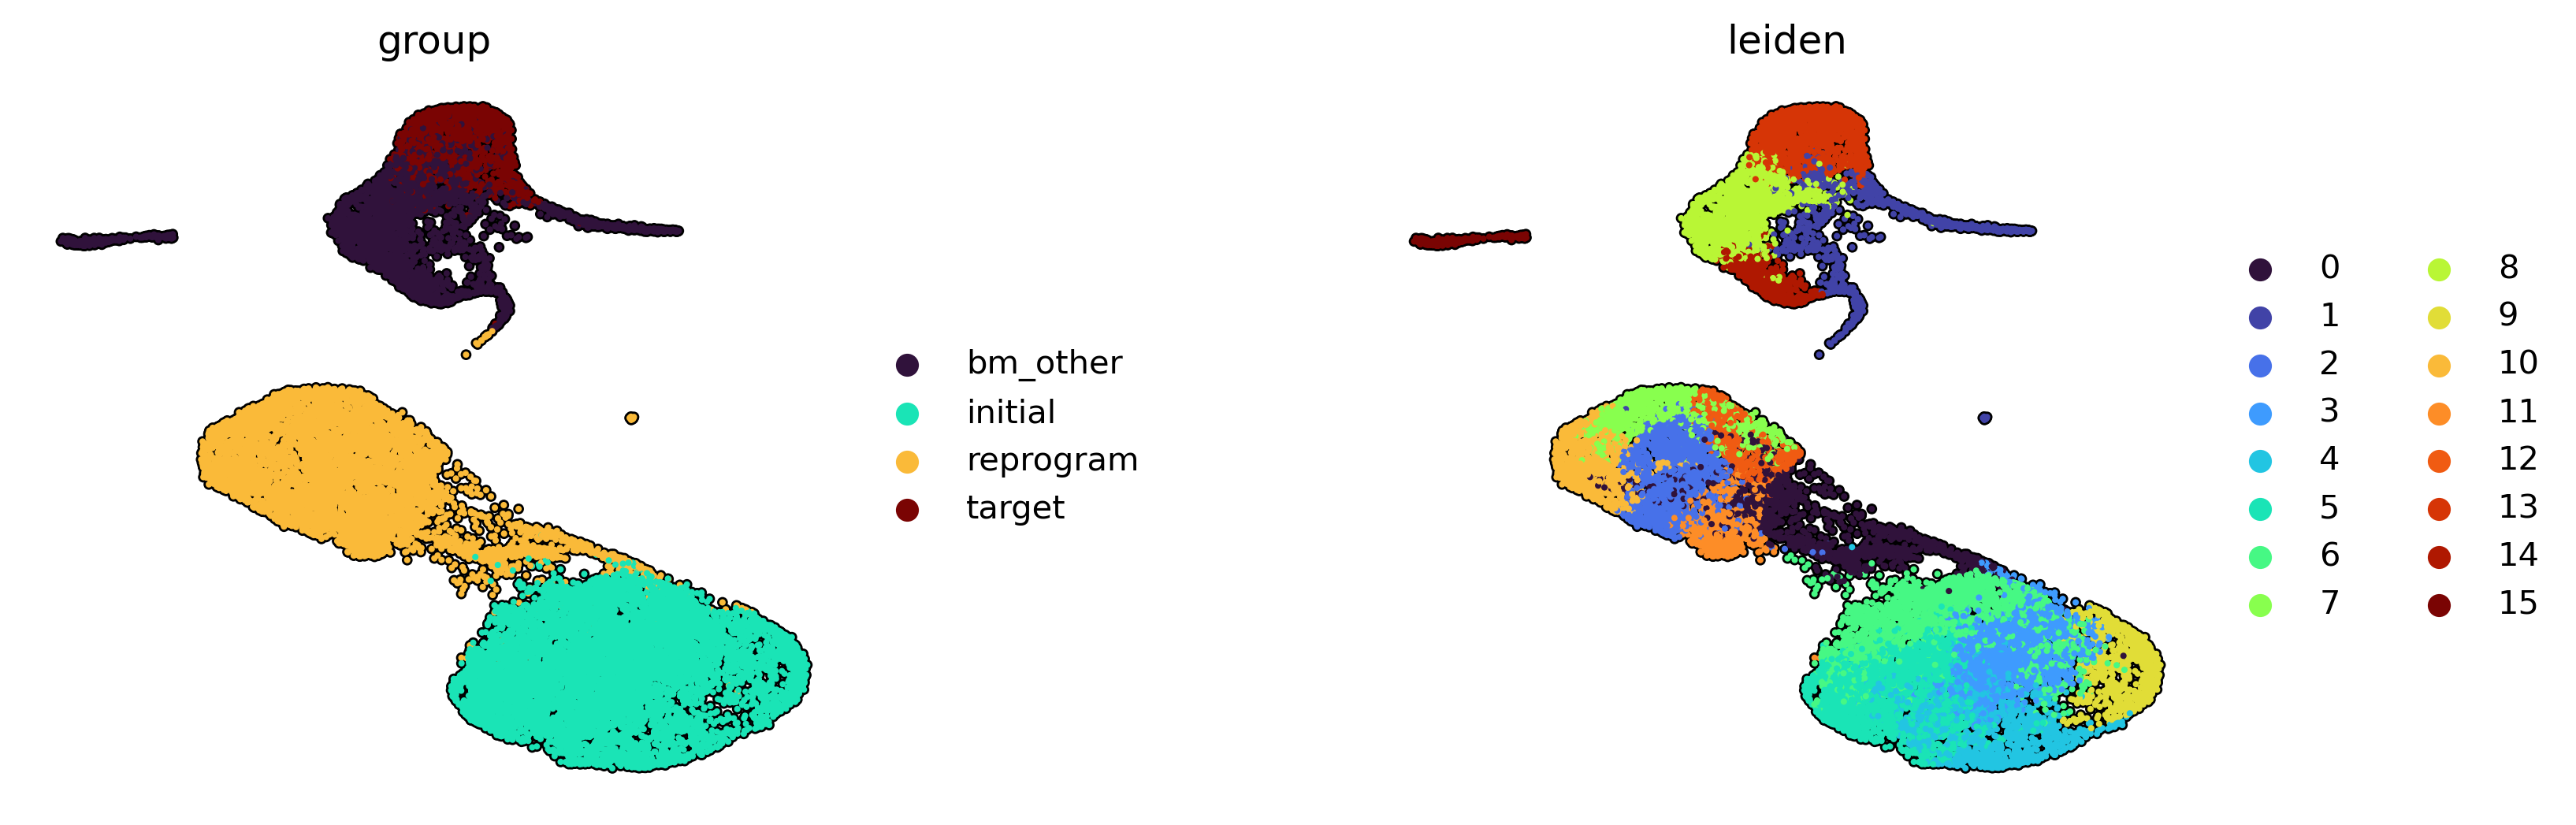

CPU times: user 2.82 s, sys: 172 ms, total: 3 s
Wall time: 3.04 s


In [25]:
%%time 

n_neighbors = 35 # 35
paga_group_column = "label"
n_pcs = 50
min_dist = 0.2 # 0.2
spread = 0.55
leiden_resolution = 0.65
colormap = 'turbo'

"""
PAGA
"""
embed = model.get_latent_representation()
embed = sc.AnnData(embed, obs=adata.obs)

rsc.get.anndata_to_GPU(embed)
rsc.pp.pca(embed)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4, 2
sc.pl.pca_variance_ratio(embed)
rsc.pp.neighbors(
    embed, 
    n_pcs=n_pcs, 
    n_neighbors=n_neighbors,
)

# plot the embedding
sc.tl.paga(embed, groups=paga_group_column)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
sc.pl.paga(
    embed, 
    fontoutline=1.5, 
    edge_width_scale=0.25,  
    frameon=False,          
)

embed.obsm['X_paga'] = get_init_pos_from_paga(embed)

"""
UMAP
"""
# get the inputs
init_pos = embed.obsm['X_paga'].copy()
data = embed.X.copy()
graph = embed.obsp['connectivities'].copy()

print(f"{init_pos.shape=} {type(init_pos)=}")
print(f"{data.shape=} {type(data)=}")
print(f"{graph.shape=} {type(graph)=}")

# find params
a, b = find_ab_params(spread=spread, min_dist=min_dist)
print(f"{min_dist=} {spread=} {a=} {b=}")

# use simplicial_set_embedding
embedding = simplicial_set_embedding(
    data=data,
    graph=graph,
    a=a, b=b,
    n_components=2,
    init=init_pos,
    random_state=1729,
)

# store embedding
print(f"{embedding.shape=} {type(embedding)=}")
# embed.obsm['X_umap'] = embedding.to_device_array().get().copy()

if hasattr(embedding, "to_device_array"):  # cuML CumlArray
    embed.obsm['X_umap'] = embedding.to_device_array().get().copy()
elif hasattr(embedding, "get"):  # cupy ndarray
    embed.obsm['X_umap'] = embedding.get().copy()
else:  # numpy ndarray
    embed.obsm['X_umap'] = embedding.copy()

rsc.tl.leiden(embed, resolution=leiden_resolution)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.umap(
    embed, 
    color=['group', 'leiden'], 
    size=15,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    palette=colormap,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.5,
)

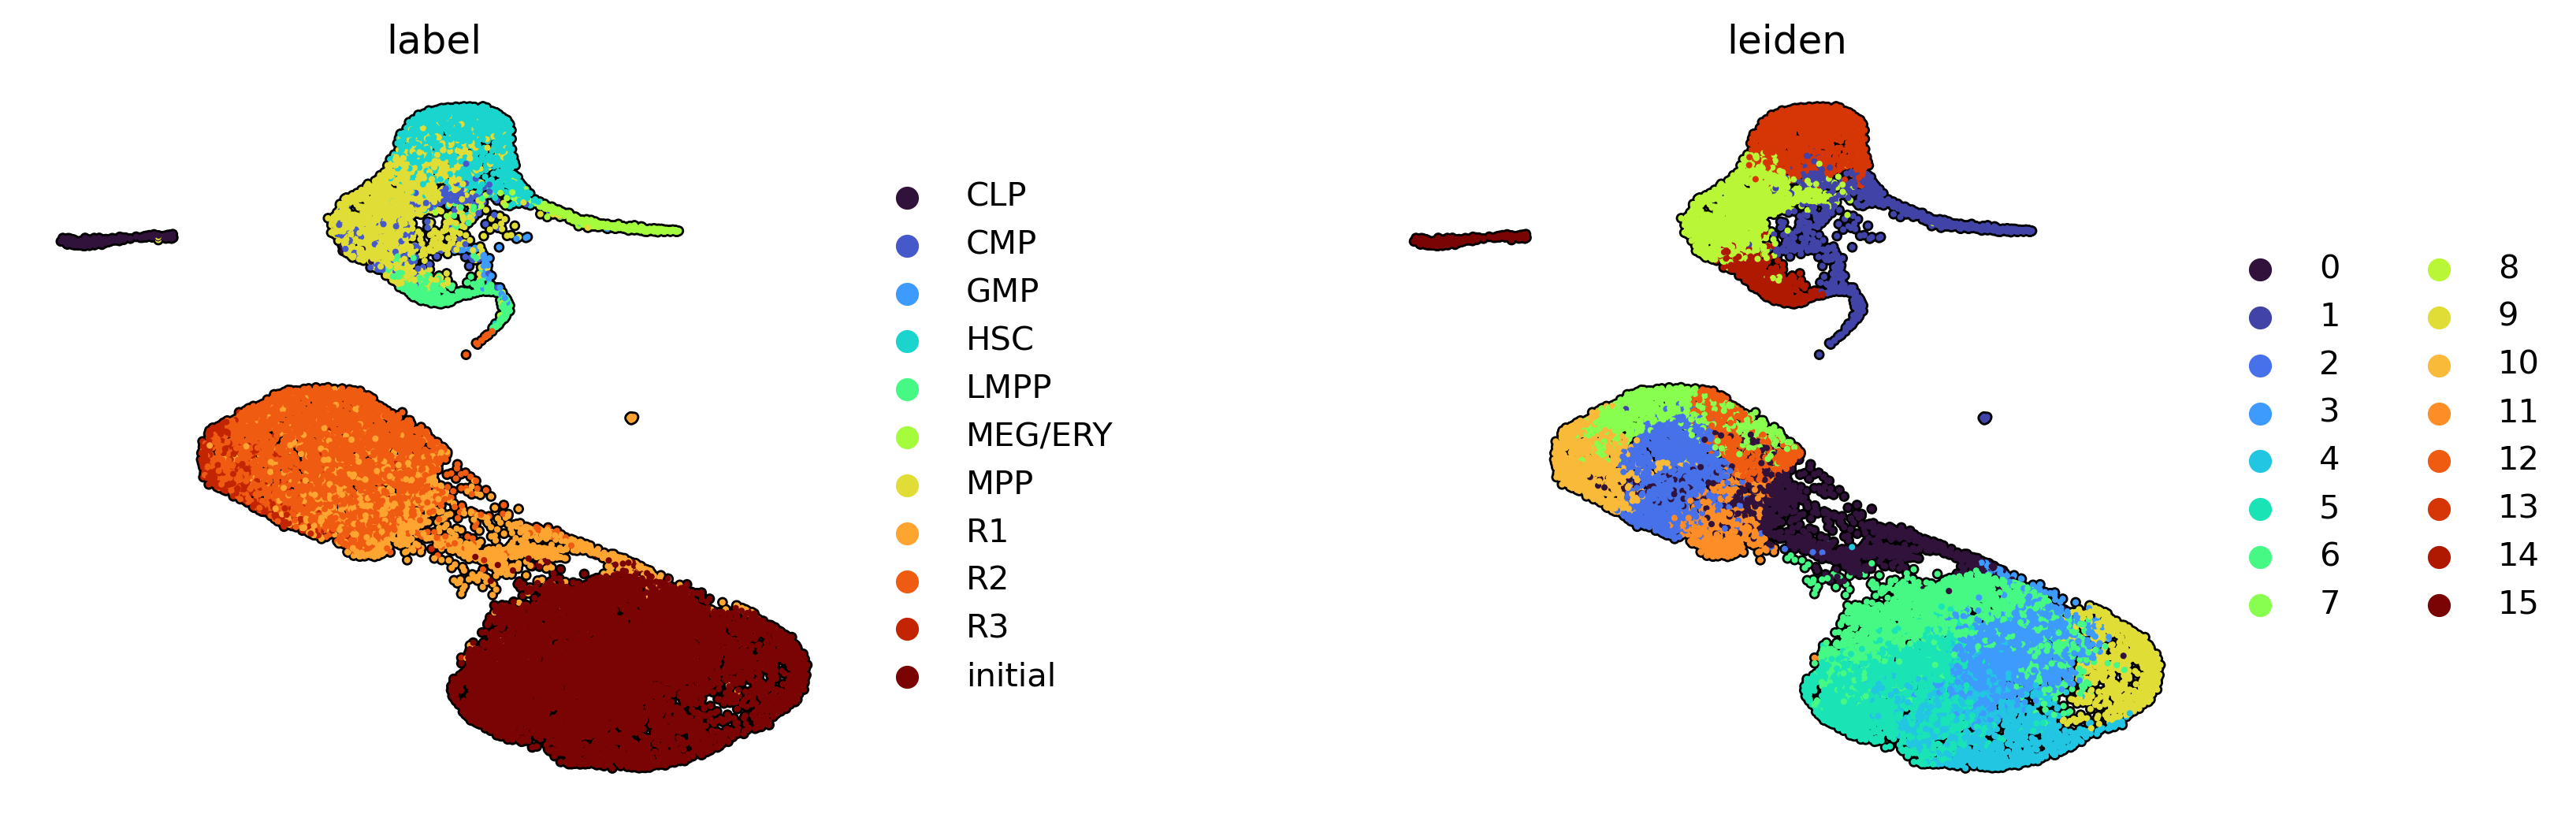

In [23]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.umap(
    embed, 
    color=['label', 'leiden'], 
    size=15,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    palette=colormap,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.5,
)

# add embedding into Adata

... storing 'dataset' as categorical
... storing 'source' as categorical
... storing 'cluster_all' as categorical
... storing 'group' as categorical
... storing 'label' as categorical
... storing 'phase' as categorical
... storing 'gene_ids' as categorical



['MPP', 'MEG/ERY', 'CMP', 'HSC', 'LMPP', 'CLP', 'GMP', 'R2', 'initial', 'R1', 'R3']


... storing 'gene_id' as categorical


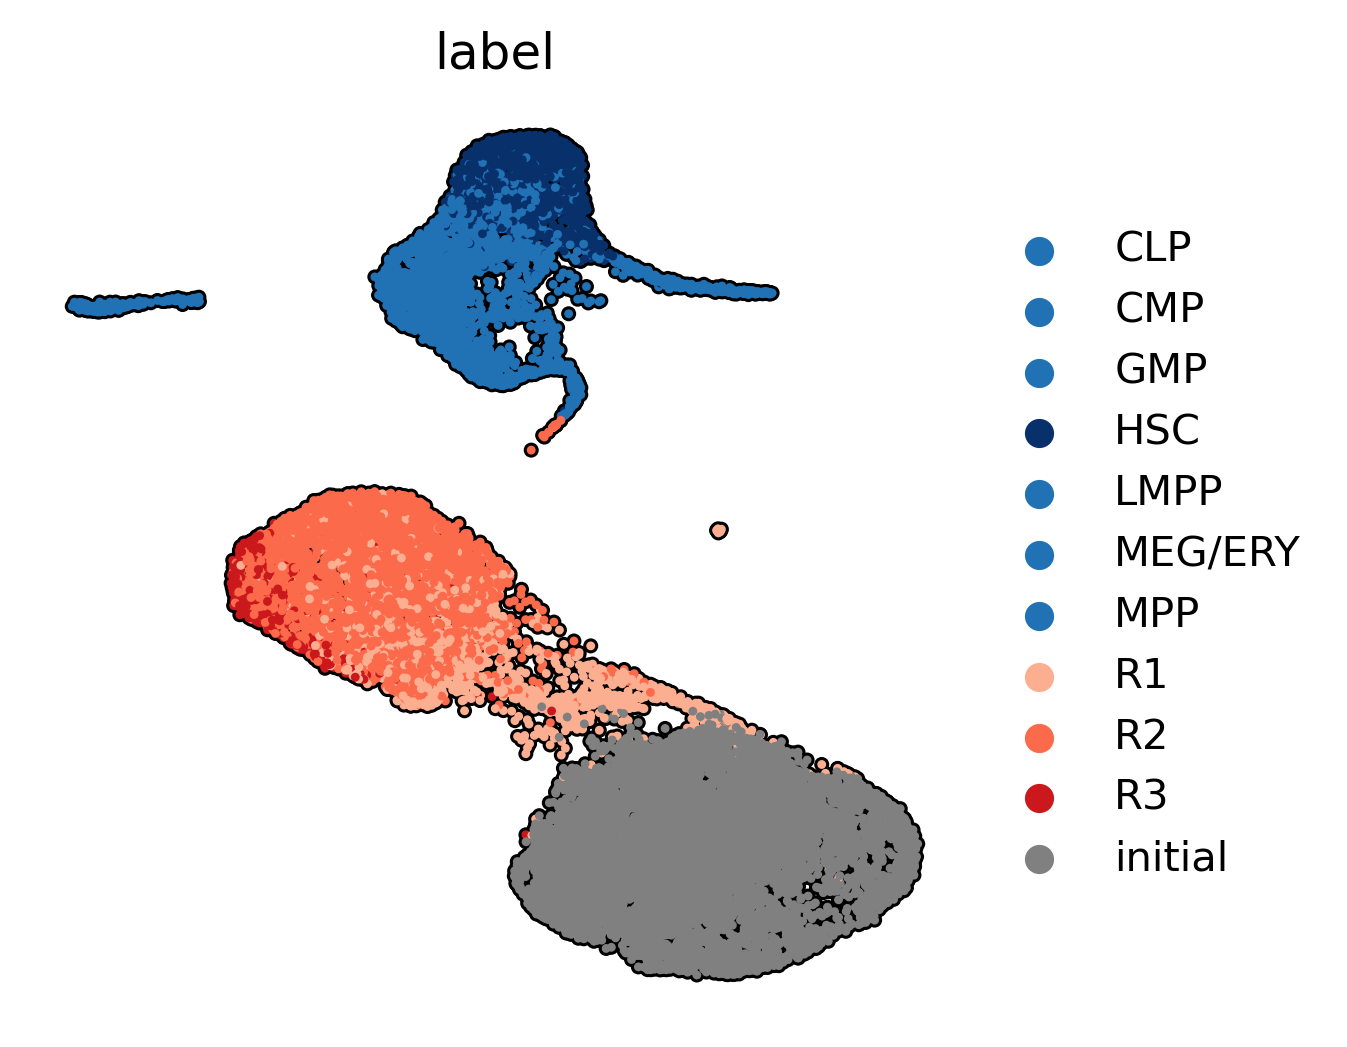

AnnData object with n_obs × n_vars = 20754 × 26933
    obs: 'dataset', 'source', 'cluster_all', 'group', 'label', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'combined_clusters'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_id', 'gene_type', 'Chromosome', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_rank', 'variances', 'variances_norm', 'mito', 'filter_pass'
    uns: 'label_colors'
    obsm: 'X_pca', 'X_umap'

In [26]:
adata.obsm['X_paga'] = embed.obsm['X_paga'].copy()
adata.obsm['X_umap'] = embed.obsm['X_umap'].copy()
adata.obsm['X_scvi'] = embed.X.copy()

# get filter column
adata.obs['combined_clusters'] = embed.obs['leiden'].apply(lambda x: f"M{int(x) + 1}")
# adata.obs['filter_pass'] = embed.obs['filter_pass'].copy().astype(bool)

# print(adata.obs['filter_pass'].value_counts().to_string())


print()
print(list(adata.obs['label'].unique()))

palette = {
    # HSC group – blues
    'HSC'     : '#08306B',
    'GMP'      : '#2171B5',
    'MPP'     : '#2171B5',
    'MEG/ERY' : '#2171B5',
    'CMP'     : '#2171B5',
    'LMPP'    : '#2171B5',#'limegreen',
    'CLP'     : '#2171B5',#'b',

    # reprogram group – reds
    'R1'      : '#FCAE91',
    'R2'      : '#FB6A4A',
    'R3'      : '#CB181D',

    # initial group – neutral grey
    'initial'  : '#808080',
}


sc.pl.umap(
    # adata[adata.obs['filter_pass']], 
    adata,
    color='label', 
    size=18,
    ncols=3,
    alpha=1,
    use_raw=False,
    na_in_legend=False,
    palette=palette,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.5,
)

adata

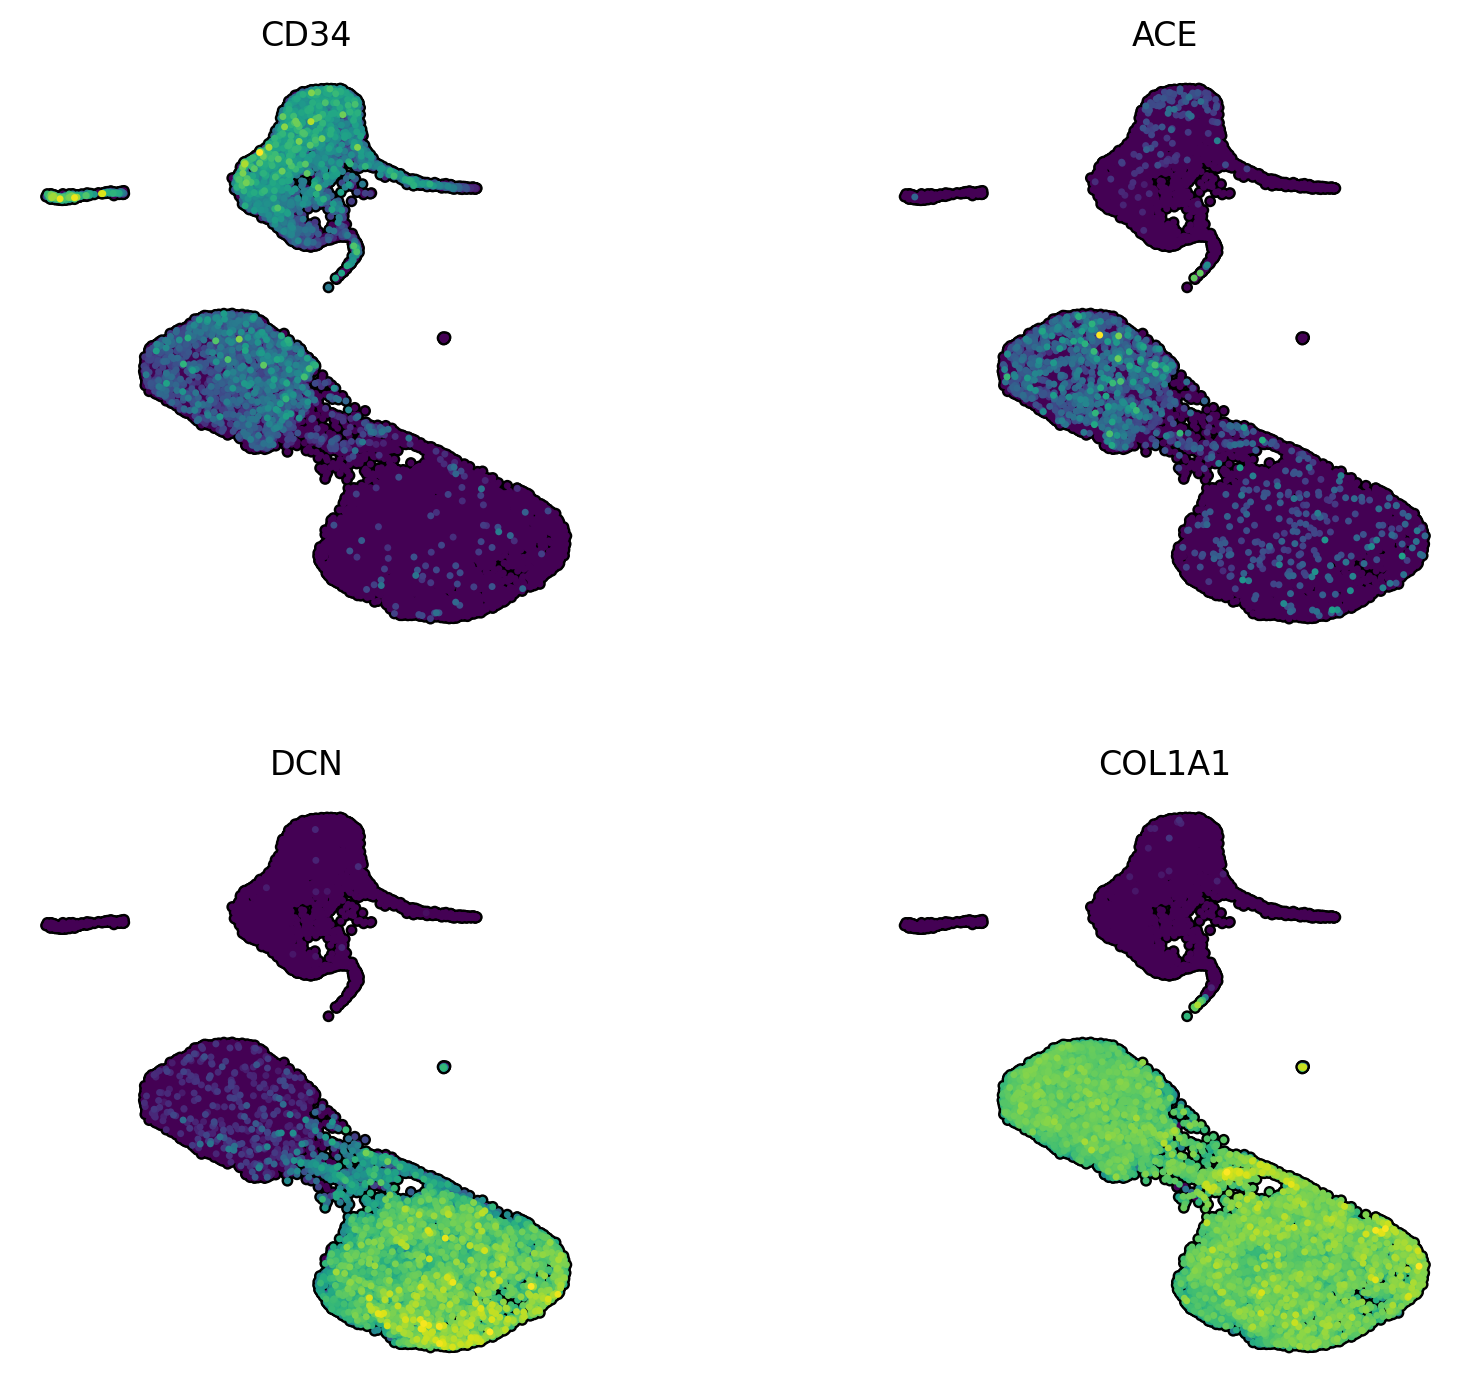

In [27]:
rsc.get.anndata_to_CPU(adata)

gene_list = [
    'CD34', 'ACE',
    'DCN', 'COL1A1',
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 4

sc.pl.umap(
    adata, 
    color=gene_list,
    size=25,
    ncols=2,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    colorbar_loc=None,
    frameon=False,
    wspace=0.5,
)

# DEG

In [34]:
adata.obs['label'] = adata.obs['label'].str.replace('/', '-', regex=False)
adata.obs['label'].value_counts()

label
initial    8464
R2         4323
MPP        2162
R1         1985
HSC        1506
R3          524
CLP         500
LMPP        496
MEG-ERY     440
CMP         302
GMP          52
Name: count, dtype: int64

ranking genes


... storing 'label' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:50)

filter_pass
False    273295
True      22968


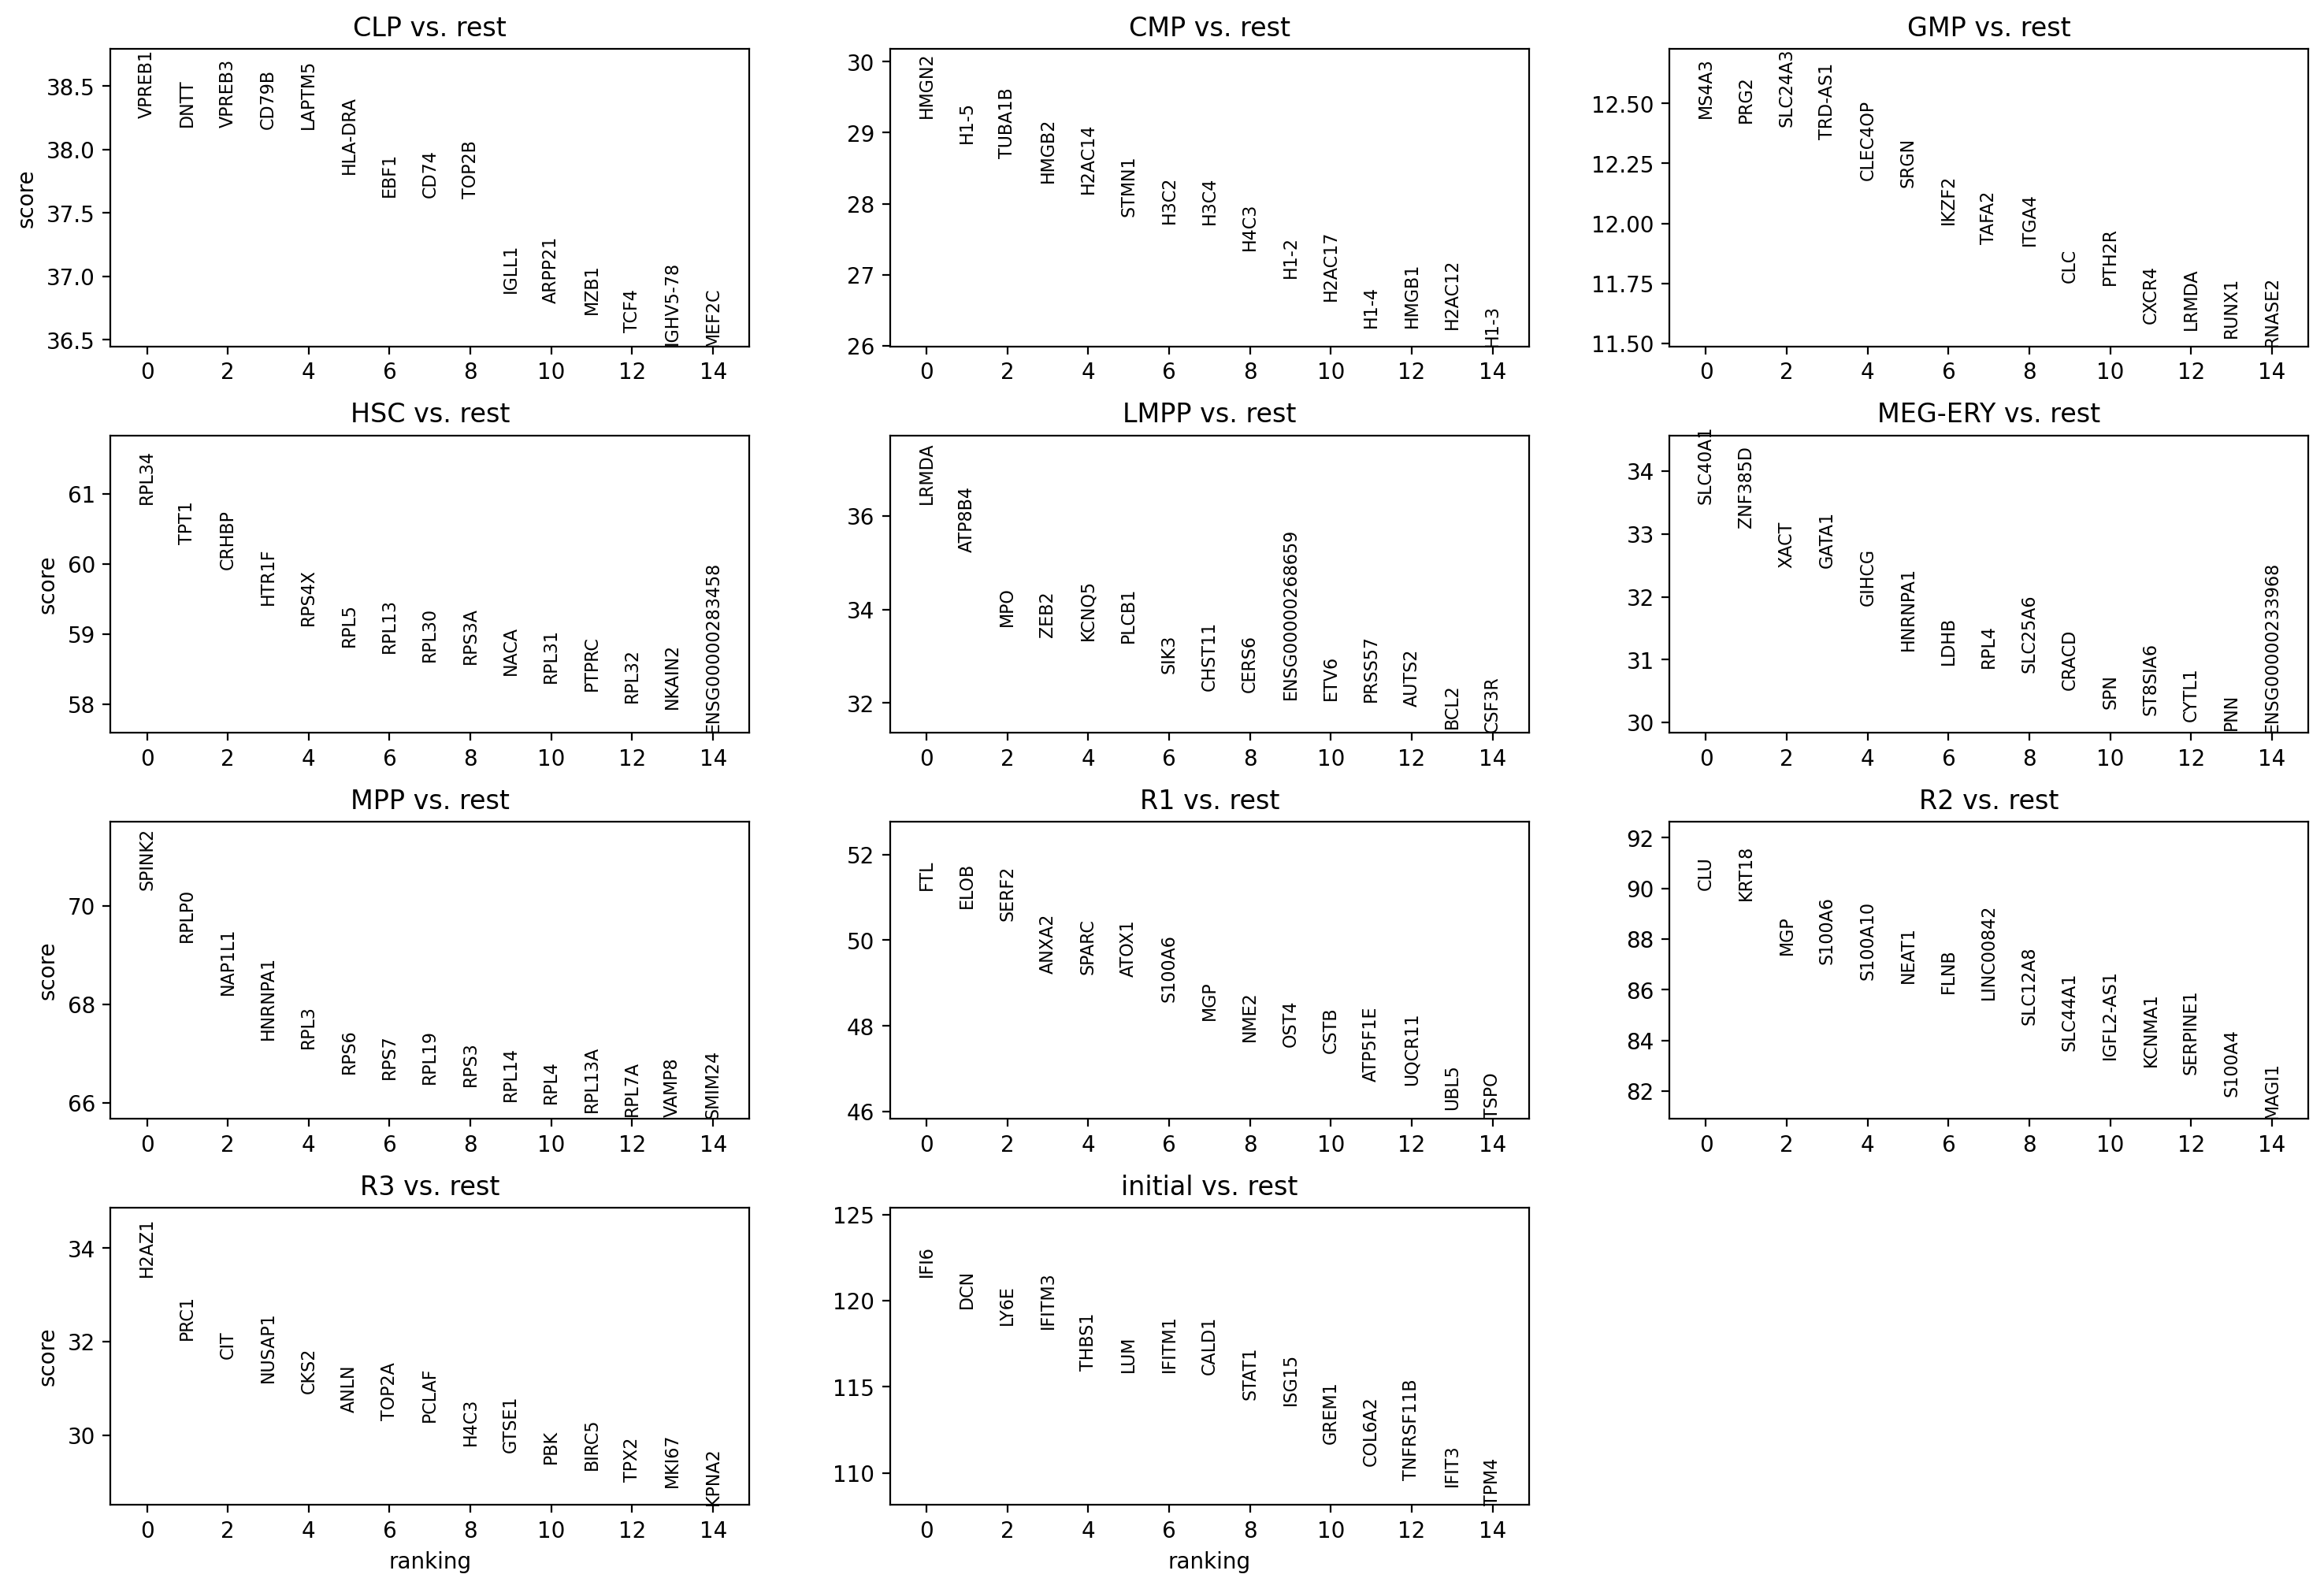

CPU times: user 43.6 s, sys: 8.05 s, total: 51.7 s
Wall time: 52.1 s


group   names     scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
0   CLP  VPREB1  38.251358        9.368893    0.0        0.0         1.000   
1   CLP    DNTT  38.182858        9.224579    0.0        0.0         1.000   
2   CLP  VPREB3  38.176781       12.615062    0.0        0.0         0.998   
3   CLP   CD79B  38.160126        8.120173    0.0        0.0         0.998   
4   CLP  LAPTM5  38.159904        5.808619    0.0        0.0         1.000   

   pct_nz_reference  filter_pass  
0          0.057668         True  
1          0.038955         True  
2          0.003851         True  
3          0.104473         True  
4          0.218080         True

In [35]:
%%time

sc.tl.rank_genes_groups(
    adata, 
    groupby='label',
    method='wilcoxon',
    layer='log_norm',
    use_raw=False,
    pts=True,
)

deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
)

# filter out some genes
deg['filter_pass'] = True
deg['filter_pass'] = np.where(deg['names'].str.startswith('RP'), False, deg['filter_pass'])
deg['filter_pass'] = np.where(deg['names'].str.startswith('MT'), False, deg['filter_pass'])
deg['filter_pass'] = np.where(deg['names'].str.startswith('ENSG'), False, deg['filter_pass'])
deg['filter_pass'] = np.where(deg['names'].str.startswith('LINC'), False, deg['filter_pass'])
deg['filter_pass'] = np.where(deg['logfoldchanges'] > 1.0, deg['filter_pass'], False )
deg['filter_pass'] = np.where(deg['pvals_adj'] < 0.05, deg['filter_pass'],  False)

print()
print(deg['filter_pass'].value_counts().to_string())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
sc.pl.rank_genes_groups(
    adata,
    n_genes=15,
    sharey=False,
    ncols=3,
)

deg.head()

/tmp/ipykernel_3182123/3258332871.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top10 = filtered.groupby('group', group_keys=False).apply(


len(top10.names)=55
len(set(top10.names))=52


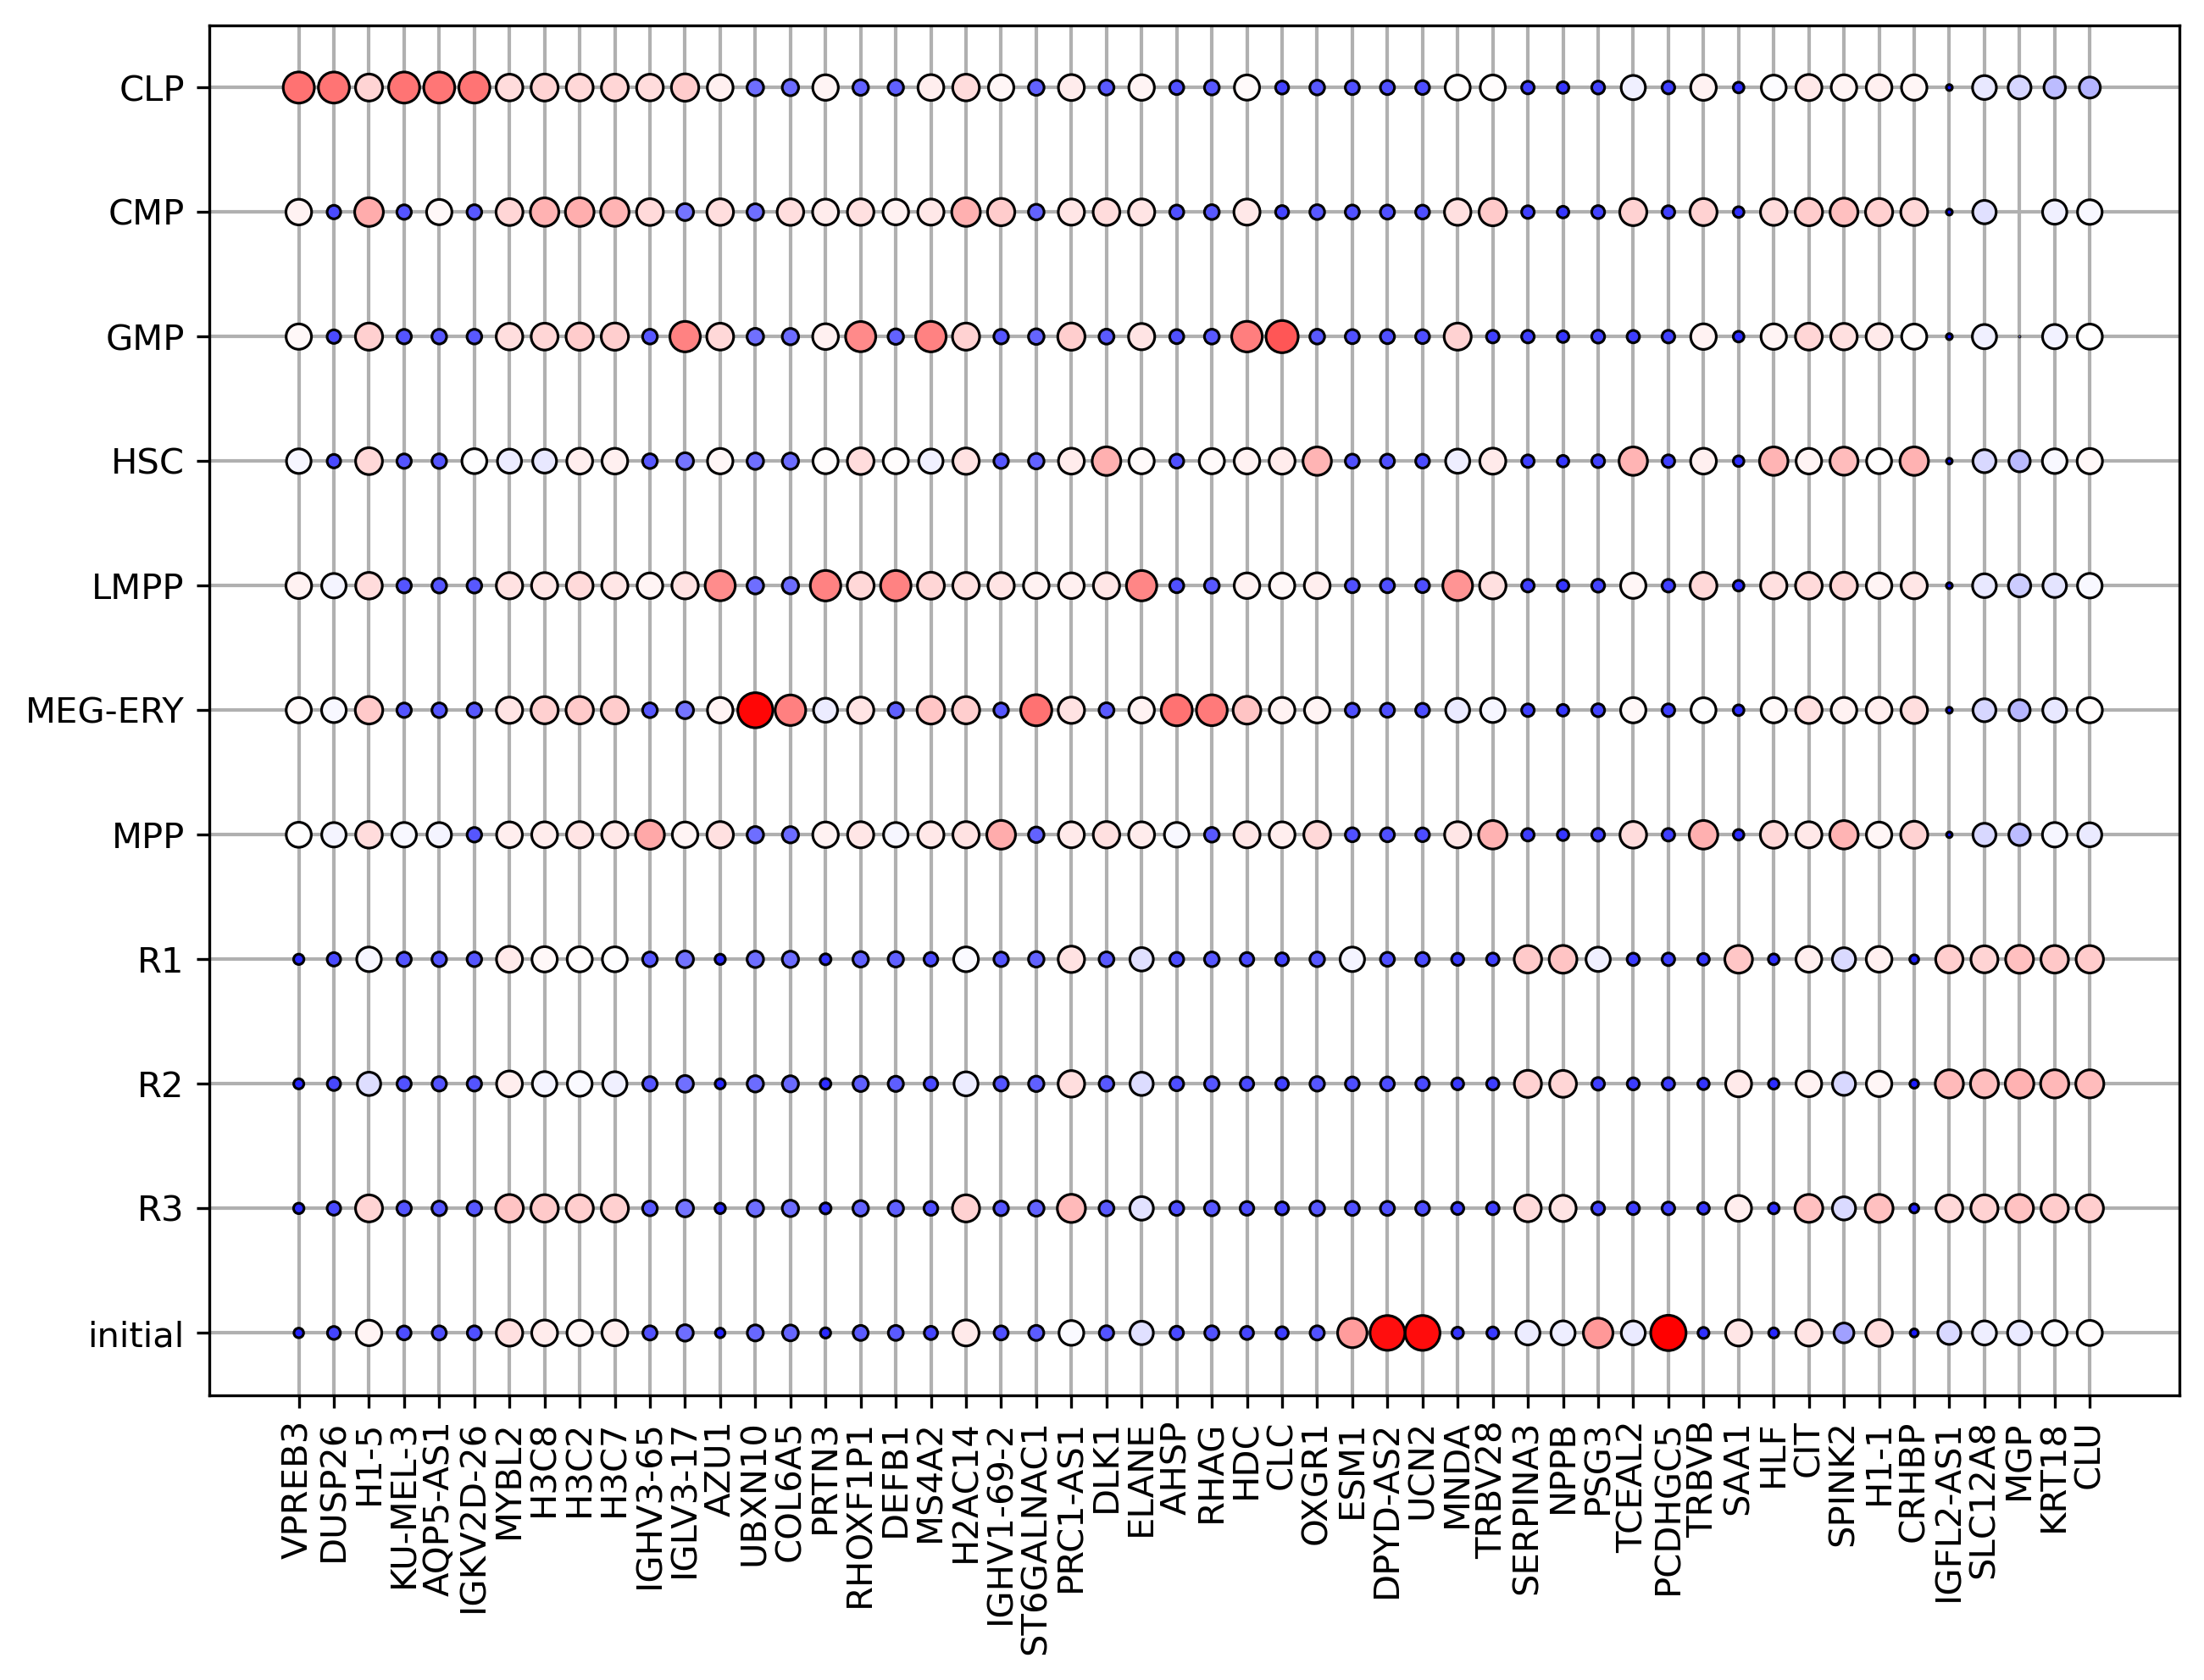

In [36]:
n_genes = 5
# Filter rows
filtered = deg[deg['filter_pass'] == True]

# Get top 10 by logfold change within each group
top10 = filtered.groupby('group', group_keys=False).apply(
    lambda g: g.nlargest(n_genes, 'logfoldchanges')
)

print(f"{len(top10.names)=}")
print(f"{len(set(top10.names))=}")

df = deg.copy()
df = df[df['names'].isin(top10.names)]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 7

sns.scatterplot(
    data=df, 
    x='names',
    y='group',
    size='logfoldchanges',
    hue='logfoldchanges',
    vmin=-2,
    vmax=2,
    sizes=(0, 100),
    ec='k',
    lw=0.75,
    legend=False,
    palette='bwr',
    zorder=10,
)

plt.ylabel("")
plt.xlabel("")
plt.xticks(rotation=90)
plt.grid(True, lw=1, zorder=0)
plt.show()

# add normalized expression 

In [37]:
adata.uns['scvi_expression'] = model.get_normalized_expression()
adata.uns['label_deg'] = deg.copy()
adata

AnnData object with n_obs × n_vars = 20754 × 26933
    obs: 'dataset', 'source', 'cluster_all', 'group', 'label', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'combined_clusters'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_id', 'gene_type', 'Chromosome', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_rank', 'variances', 'variances_norm', 'mito', 'filter_pass'
    uns: 'label_colors', 'rank_genes_groups', 'scvi

In [39]:
subgroup_label = {
    'HSC'     : 'HSC',
    'GMP'      : 'progenitors',
    'MPP'     : 'progenitors',
    'MEG-ERY' : 'progenitors',
    'CMP'     : 'progenitors',
    'LMPP'    : 'LMPP',
    'CLP'     : 'CLP',
    'R1'      : 'R1',
    'R2'      : 'R2',
    'R3'      : 'R3',
    'initial'  : 'initial',
}

adata.obs['subgroup'] = adata.obs['label'].map(subgroup_label)
print(adata.obs['subgroup'].value_counts().to_string())

subgroup
initial        8464
R2             4323
progenitors    2956
R1             1985
HSC            1506
R3              524
CLP             500
LMPP            496


# write out

In [40]:
%%time
outpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/three_libraries_new.h5ad"

# move to CPU
rsc.get.anndata_to_CPU(adata, convert_all=True)

# fix data typing issues in var
adata.var['mt'] = adata.var['mt'].astype(bool)
adata.var['hb'] = adata.var['hb'].astype(bool)
adata.var['highly_variable'] = adata.var['highly_variable'].astype(bool)
adata.var['highly_variable_intersection'] = adata.var['highly_variable_intersection'].astype(bool)

adata.write(outpath)
adata

... storing 'subgroup' as categorical


CPU times: user 2.83 s, sys: 874 ms, total: 3.71 s
Wall time: 17.2 s


AnnData object with n_obs × n_vars = 20754 × 26933
    obs: 'dataset', 'source', 'cluster_all', 'group', 'label', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'combined_clusters', 'subgroup'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_id', 'gene_type', 'Chromosome', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_rank', 'variances', 'variances_norm', 'mito', 'filter_pass'
    uns: 'label_colors', 'rank_genes_gr